***Variational Autoencoder***

https://github.com/llSourcell/autoencoder_explained/blob/master/variational_autoencoder.py (Siraj)  
https://blog.keras.io/building-autoencoders-in-keras.html (Keras blog)  
https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py (Keras blog, Github)

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
from keras import regularizers, metrics
from keras.datasets import mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from livelossplot import PlotLossesKeras
from scipy.stats import norm

**Import dataset** (MNIST)

In [2]:
# MNIST dataset

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

**Build model**

In [ ]:
original_dim = 784 # 28*28
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

Variable names explained: 
- ```x``` is the input layer (784 units)
- ```h``` is the encoder's hidden layer (256 units)
- ```z_mean```, ```z_log_var``` and ```z``` are the bottleneck layer (16 units)
- ```h_decoded``` is the decoder's hidden layer (256 units) 
- ```x_decoded_mean``` is the output layer (784 units)  

We also save the layer from ```z``` zo ```h_decoded``` as ```decoder_h``` because we want to access it later.  
We do the same for the layer from ```h_decoded``` to ```x_decoded_mean```, which we'll call ```decoder_mean```.

![](imgs/vae 3.png)

In [ ]:
# Encoder:

x = Input(shape = (original_dim,)) 
h = Dense(intermediate_dim, activation = "relu")(x) 

In [ ]:
# Bottleneck layer:

z_mean = Dense(latent_dim)(h) # "Bottleneck layer: mu"
z_log_var = Dense(latent_dim)(h) # "Bottleneck layer: sigma"

# Function that allows us to sample from the latent space by using the parameterization trick (epsilon)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(
        shape = (K.shape(z_mean)[0], latent_dim), 
        mean = 0, 
        stddev = epsilon_std)
    return z_mean + K.exp(z_log_var/2)*epsilon

# Note: "output shape" is not necessary with TensorFlow backend
z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])
# z takes two layers as its input: z_mean, z_log_var. This works because we have defined z as a Lambda,
# which means we have defined our own function: sampling, which takes two inputs: z_mean, z_log_var

# keras.layers.Lambda(function, output_shape=None, mask=None, arguments=None)
# Wraps arbitrary expression as a Layer object. In our case: sampling.
# e.g. model.add(Lambda(lambda x: x ** 2))

In [ ]:
# Decoder:

# Instantiate layers separately so that we can reuse them later

decoder_h = Dense(intermediate_dim, activation = "relu")
h_decoded = decoder_h(z) 

decoder_mean = Dense(original_dim, activation = "sigmoid")
x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
# Variational Autoencoder: putting it all together
autoencoder = Model(x, x_decoded_mean)

xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean) # xent is type of loss function
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
loss = K.mean(xent_loss + kl_loss)

autoencoder.add_loss(loss)
autoencoder.compile(optimizer = "rmsprop")

autoencoder.summary()

**Train model**

In [ ]:
start_time = time.time()

epochs = 5
batch_size = 100

autoencoder.fit(
    X_train,
    shuffle = True,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test, None),
    callbacks = [PlotLossesKeras()])

end_time = time.time() - start_time
print(f"Training time: {end_time} seconds for {epochs} epochs")
print(f"Training time: {end_time/epochs} per epoch on average")

**Build model: generator**

In [ ]:
# Model (encoder) to project inputs on the latent space 

encoder = Model(x, z_mean)

In [ ]:
# Display a 2D plot of the digit classes in the latent space
# That's why we chose latent_dim of 2

X_test_encoded = encoder.predict(X_test, batch_size = batch_size)

plt.figure(figsize = (6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c = y_test)
plt.colorbar()
plt.show()

In [ ]:
# Model (decoder/generator) that can sample from the learned distribution

decoder_input = Input(shape = (latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)

generator = Model(decoder_input, _x_decoded_mean)

**Save model**

In [ ]:
generator.save("Models/vae_generator.model")

**Load model**

In [5]:
generator = load_model("Models/vae_generator.model")

/Users/janikeuskirchen/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


**Display output**

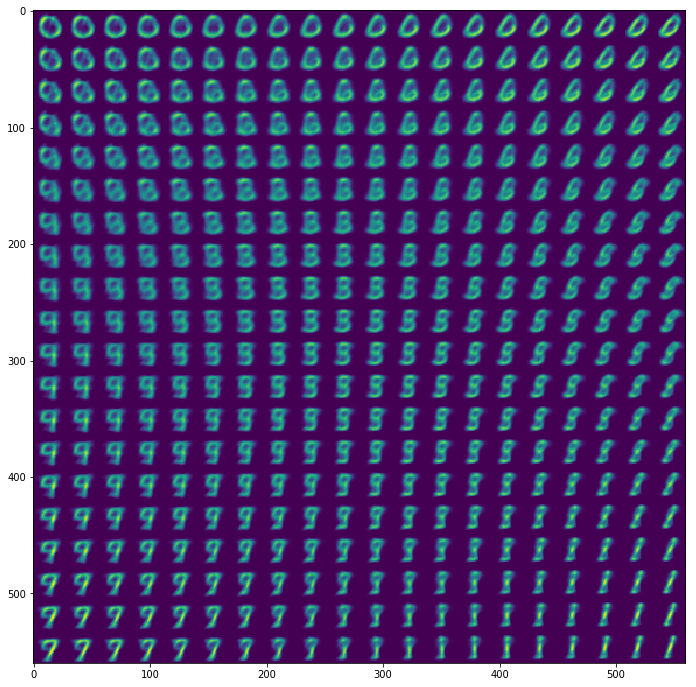

In [6]:
# Display a 2D manifold of the digits

n = 20 # figure with 15x15 digits
digit_size = 28 # 28x28

figure = np.zeros((digit_size*n, digit_size*n))

# Linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size : (i+1)*digit_size, j*digit_size : (j+1)*digit_size] = digit

plt.figure(figsize = (12, 12))
plt.imshow(figure)
plt.show()